# Лабораторная работа 3

## Общая информация

**Дата выдачи**: 07.10.2022/10.10.2022

**Срок сдачи**: 21.10.2022/24.10.2022 *(Но требуется обязательная демонстрация текущего прогресса преподавателю во время лабораторного занятия 14.10.2022/17.10.2022)*

### О задании
Целью данного задания является ознакомление с основными методами понижения размерностей, первичной оценкой кластеризации и кластеризацией.

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов.

Сдача заданий после указанного срока сдачи ведёт к снижению оценки.

Задание выполняется САМОСТОЯТЕЛЬНО. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

### Формат сдачи
** Устная защита выполненной лабораторной работы ОБЯЗАТЕЛЬНА! **

После успешной устной защиты переименуйте получившийся файл `*.ipynb` в соответствии со следующим форматом: *Username_lab_2.ipynb*, где Username — ваша фамилия на латинице (например, `lehusheu_lab_3.ipynb`) и отправьте этот файл электронной почтой по адресу `dmitri.legushev.bsu@gmail.com` c темой письма *Фамилия преподавателя - Лабораторная работа 2 - Фамилия Имя Отчество* (для обоих подгрупп). Подгруппа Атрохова Кирилла Георгиевича также ставит в копию адрес `kiryl.atrokhau+ml2022@gmail.com`. Это будет являться письменным отчетом о выполнении лабораторной работы.

**Данные:** Представленные данные отображают поведение 8950 активных держателей кредитных карт за последние 6 месяцев. В датасете представлены 18 подведенческих признаков клиента.

**Задача:** Необходимо разработать сегментацию клиентов для определения маркетинговой стратегии.

**Подробнее о данных:** https://www.kaggle.com/datasets/arjunbhasin2013/ccdata 

In [1]:
import sys
from time import time
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler,KBinsDiscretizer,OneHotEncoder,PowerTransformer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from numpy.random import uniform
from random import sample
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import Birch
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import v_measure_score,homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from kneed import KneeLocator
#from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

In [2]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X,eps=False):
    
    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    if eps:
        return np.mean(u_distances),np.mean(w_distances)
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

1. Необходимо загрузить данные. Изучить признаки, представленные в датасете. Определить какой тип признаков (категориальные, текстовые, числовые). Определить, есть ли в датасете пропуски, если есть, то по одной из стратегий произвести  чистку данных.

In [3]:
train = pd.read_csv('data/CC GENERAL.csv')

In [4]:
train.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [5]:
train.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [6]:
cust_id = train.CUST_ID
train.CREDIT_LIMIT = train.CREDIT_LIMIT.fillna(train.CREDIT_LIMIT.mean())
train.MINIMUM_PAYMENTS = train.MINIMUM_PAYMENTS.fillna(train.MINIMUM_PAYMENTS.mean())
train = train.drop(columns=['CUST_ID'])

In [7]:
train.isna().sum().sum()

0

2. Построить графики распределения для каждого признака (библиотека seaborn - sns.displot / plt.hist) и сделать вывод о характере распределения. Подсказка: в большинстве признаков распределение экспоненциальное. Эффективным подходом к переходу от экпоненциального к нормальному распределению - логарифмирование значений признака.

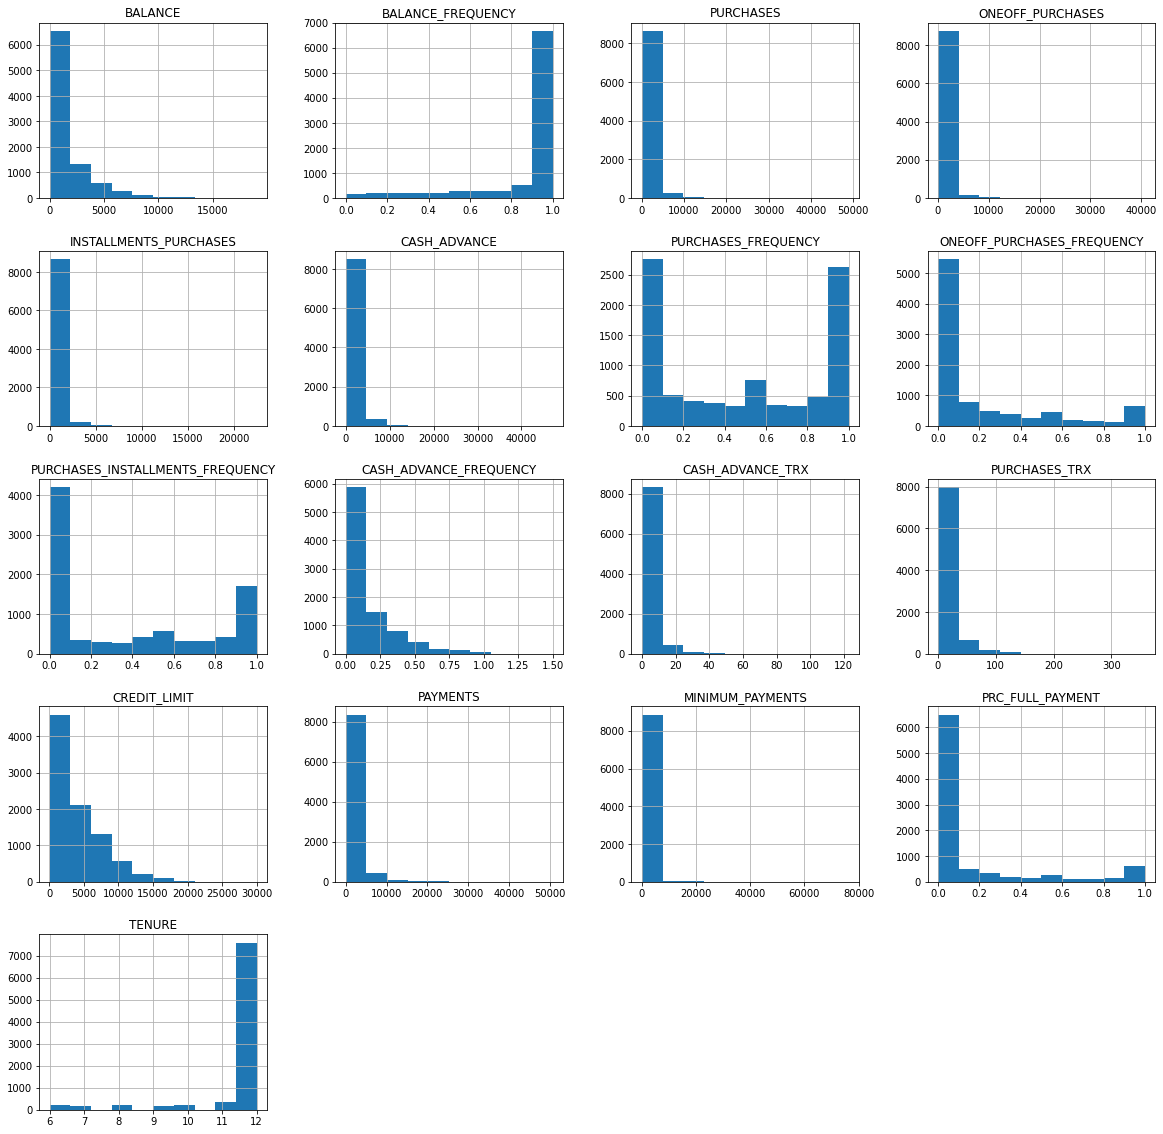

In [8]:
train.hist(figsize=(20,20))
plt.show()

3. Необходимо отнормировать признаки. Для числовых - по одной из стратегий (MinMax, StandartScaler и др.). Для категориальных - применить LabelEncoder / OneHotEncoder.

In [9]:
bin_cols = ['BALANCE_FREQUENCY','PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY','CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX','PURCHASES_TRX','CREDIT_LIMIT','PRC_FULL_PAYMENT','TENURE']

In [10]:
res = pd.DataFrame()
for col in bin_cols:
    print(col)
    for i in range(5,31):
        km = KMeans(n_clusters=i).fit(np.array(train[col]).reshape(-1,1))
        res.loc[i,col] = km.inertia_

BALANCE_FREQUENCY
PURCHASES_FREQUENCY
ONEOFF_PURCHASES_FREQUENCY
PURCHASES_INSTALLMENTS_FREQUENCY
CASH_ADVANCE_FREQUENCY
CASH_ADVANCE_TRX
PURCHASES_TRX
CREDIT_LIMIT
PRC_FULL_PAYMENT
TENURE


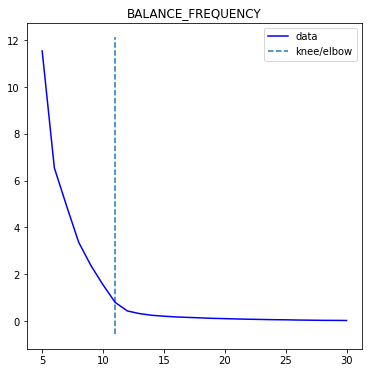

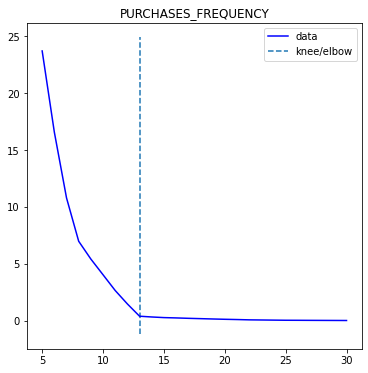

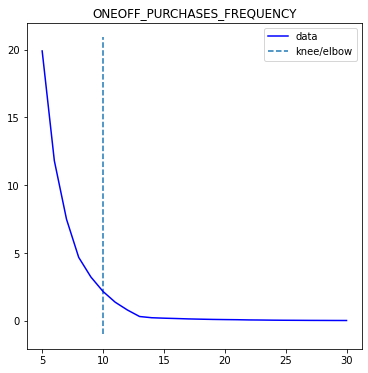

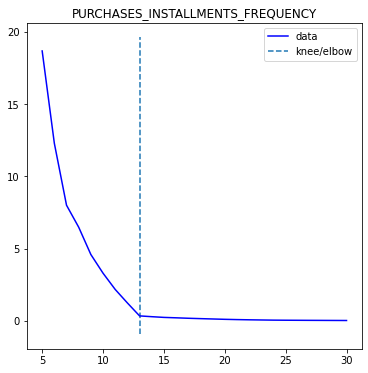

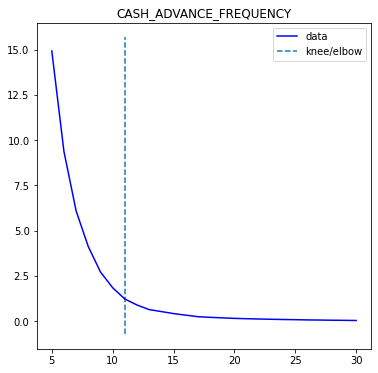

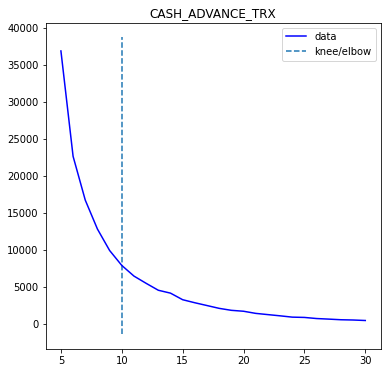

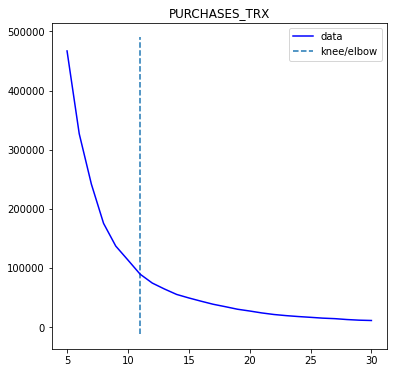

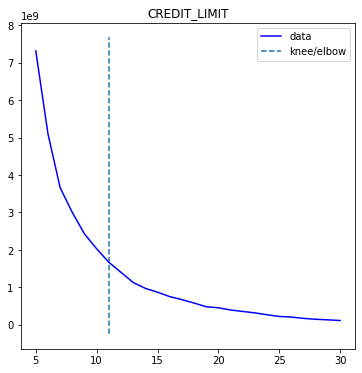

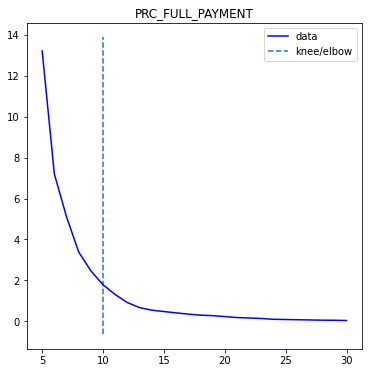

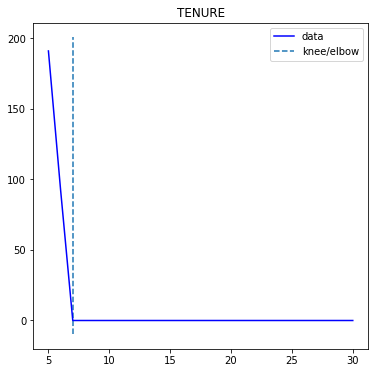

In [11]:
for i in res.keys():
    kl = KneeLocator(x=list(range(5,31)),y=res[i].to_numpy(),direction='decreasing',curve='convex')
    kl.plot_knee()
    plt.title(i)

In [12]:
for i in res.keys():
    kl = KneeLocator(x=list(range(5,31)),y=res[i].to_numpy(),direction='decreasing',curve='convex')
    tmp = KBinsDiscretizer(n_bins=kl.knee,encode='ordinal',strategy='kmeans').fit_transform(np.array(train[i]).reshape(-1,1))
    train[i] = tmp.reshape(1,-1)[0]

In [13]:
#scaler = PowerTransformer()
#train = pd.DataFrame(scaler.fit_transform(train),columns=train.keys())
other_cols = list(set(train.keys()).difference(set(bin_cols)))

train[other_cols] = np.log1p(train[other_cols])

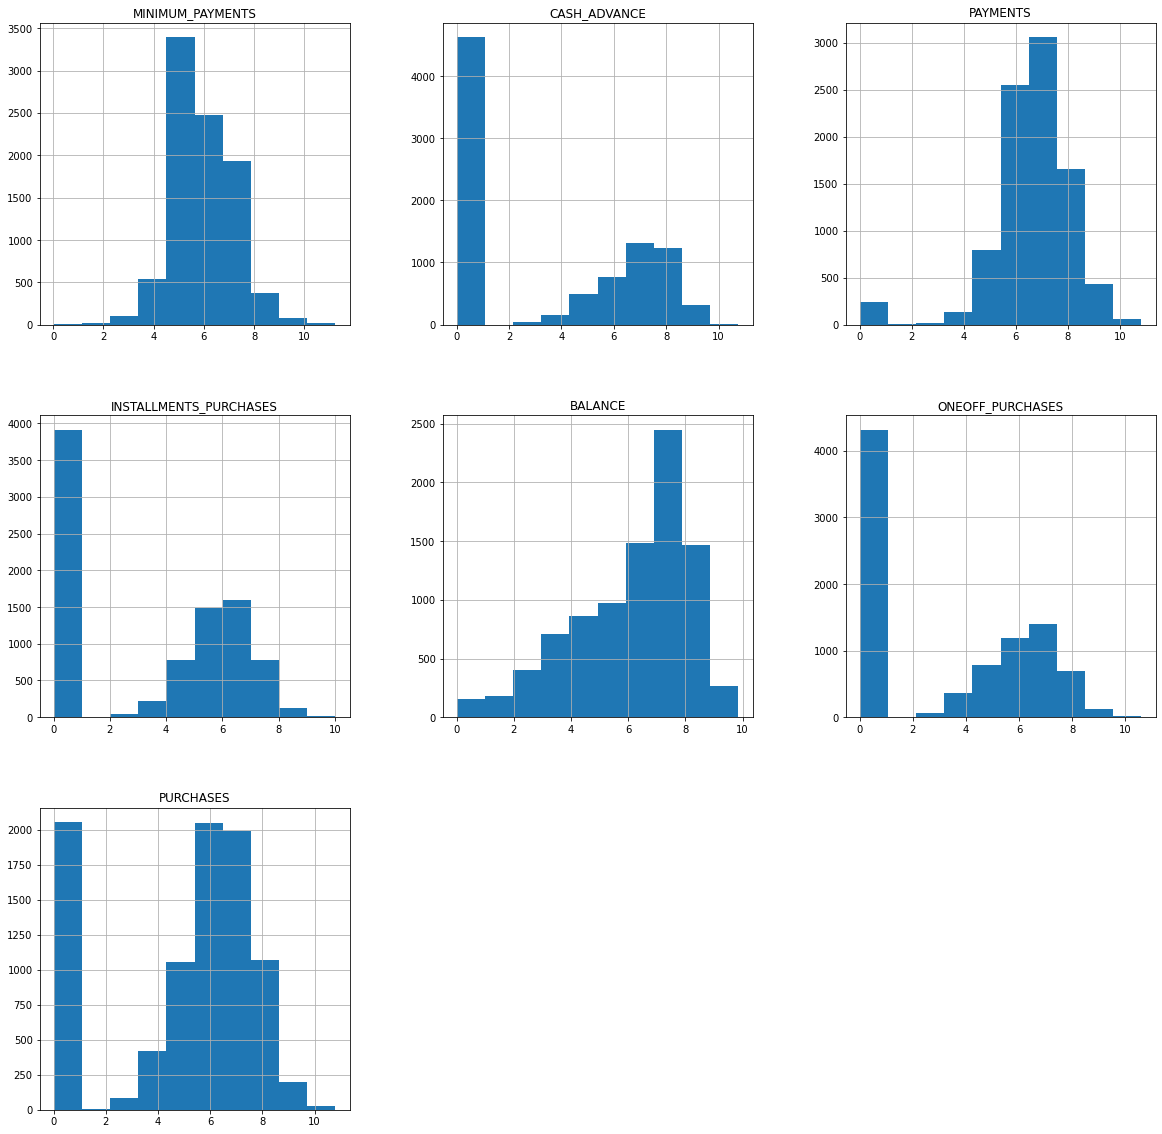

In [14]:
train[other_cols].hist(figsize=(20,20))
plt.show()

In [15]:
for i in bin_cols:
    enc = OneHotEncoder(sparse=False)
    tmp = enc.fit_transform(np.array(train[i]).reshape(-1,1))
    train = train.join(pd.DataFrame(tmp,columns=[i+"_"+str(j) for j in np.unique(enc.categories_)]))
    train = train.drop(columns=[i])

In [16]:
scaler = StandardScaler()
train_sc = pd.DataFrame(scaler.fit_transform(train),columns=train.keys())

In [17]:
train_copy = train.copy()
train = train_sc

4. С помощью алгоритмов понижения размерности (PCA, LDA, T-SNE и др.) необходимо отобразить все признаки в двумерном виде. Выбрать лучшее представление (кластеры могут быть различимы).

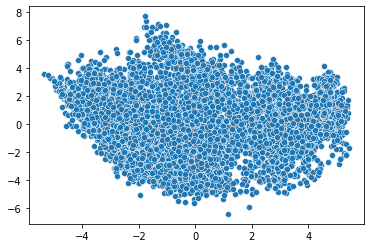

In [22]:
pca2 = PCA(n_components=2)
tmp = pca2.fit_transform(train)
sns.scatterplot(x=tmp[:,0],y=tmp[:,1])
plt.show()

In [25]:
train = pd.DataFrame(tmp)

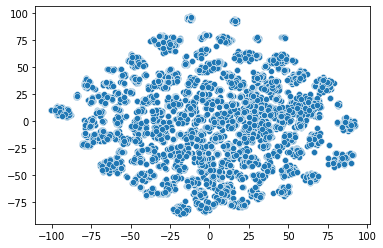

In [19]:
tsne2 = TSNE(n_components=2, learning_rate='auto', init='random',n_jobs=-1)
tmp = tsne2.fit_transform(train)
sns.scatterplot(x=tmp[:,0],y=tmp[:,1])
plt.show()

In [16]:
#draw_random_clusters(train,min_cols=20,l=100)

5. С помощью стастистики Хопкинса рассчитать тенденцию к кластеризации. Сделать вывод о тенденции.
<br> Значение статистики можно интерпретировать как:
* значения между {0.01, ...,0.3} — данные “разнесены” по пространству
* значения около 0.5 — данные случайные
* значения между {0.7, ..., 0.99} — в данных наблюдается кластерная тенденция
<br> Подробнее https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency/blob/master/Hopkins-Statistic-Clustering-Tendency.ipynb

In [68]:
print(hopkins_statistic(train))

n_cols = len(train.keys())-list(np.round(PCA(n_components = len(train.keys())).fit(train).singular_values_)).count(0)
print(n_cols)
cut_train = pd.DataFrame(PCA(n_components=n_cols).fit_transform(train))

print(hopkins_statistic(pd.DataFrame(cut_train)))

0.9191571199621126
2
0.9158013364118243


In [293]:
train_copy = train.copy()
train = tmp

6. На алгоритмах кластеризации (KMeans, Birch, GaussianMixture, AgglomerativeClustering и др.) необходимо обучить модели, получить лейблы(лейблы = модель.fit_transform(...)). Количество кластеров необходимо подобрать. 
<br> При помощи перебора в каждом алгоритме необходимо найти оптимальное число кластеров:
<br> 1) С помощью метрик silhouette_score (max значение оптимальное), davies_bouldin_score (min значние оптимальное), calinski_harabasz_score (max значение оптимальное) вычислить значение для каждого алгоритма и числа кластеров.
<br> 2) Отобразить графики значения метрик от количества кластеров. 
<br> 3) Выбрать оптимальное число кластеров.
<br> 4) Обучить модели с учетом выбранного числа кластеров.
<br> 5) По полученным лейблам и двумерном представлении данных (пункт 4) визуализировать точки (plt.scatter(..., c=лейблы, cmap='tab20'))
<br> Подробнее о метриках: https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Clustering_metrics.ipynb

In [66]:
models = []
models.append(KMeans(n_clusters=2, random_state=0).fit(train))
models.append(KMeans(n_clusters=3, random_state=0).fit(train))
models.append(KMeans(n_clusters=5, random_state=0).fit(train))
models.append(Birch(n_clusters=2).fit(train))
models.append(Birch(n_clusters=5).fit(train))
models.append(GaussianMixture(n_components=2).fit(train))
models.append(AgglomerativeClustering(n_clusters=2).fit(train))
models.append(AgglomerativeClustering(n_clusters=5).fit(train))

In [36]:
models = []
models.append(KMeans(n_clusters=2, random_state=0).fit(train))
models.append(KMeans(n_clusters=7, random_state=0).fit(train))
models.append(Birch(n_clusters=2).fit(train))
models.append(Birch(n_clusters=7).fit(train))
models.append(GaussianMixture(n_components=2).fit(train))
models.append(GaussianMixture(n_components=5).fit(train))
models.append(AgglomerativeClustering(n_clusters=2).fit(train))
models.append(AgglomerativeClustering(n_clusters=8).fit(train))

### KMeans

In [27]:
flag = False
km_silhouette = []
km_db_score = []
km_cal_har_lst = []
km_inertia = []
for i in range(2,12):
    print(i)
    km = KMeans(n_clusters=i, random_state=0).fit(train)
    preds = km.predict(train)
    
    
    silhouette = silhouette_score(train,preds)
    km_silhouette.append(silhouette)
    db = davies_bouldin_score(train,preds)
    km_db_score.append(db)
    cal_har = calinski_harabasz_score(train,preds)
    km_cal_har_lst.append(cal_har)
    km_inertia.append(km.inertia_)
    if flag:
        print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
        print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
        print("calinski-harabasz score for number of cluster(s) {}: {}".format(i,cal_har))
        print("-"*100)
print("DONE")

2
3
4
5
6
7
8
9
10
11
DONE


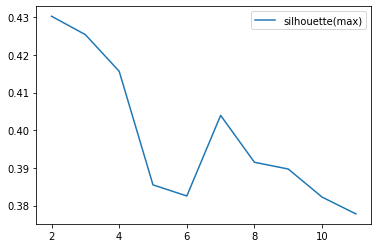

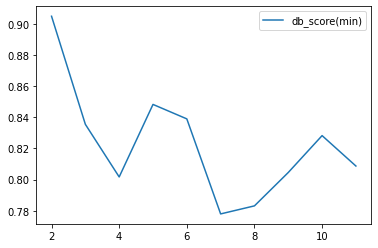

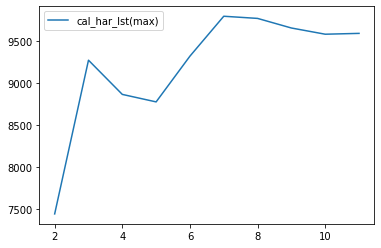

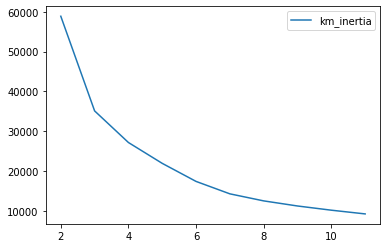

<Figure size 432x288 with 0 Axes>

In [28]:
res = [km_silhouette, km_db_score, km_cal_har_lst,km_inertia]
names = ['silhouette(max)', 'db_score(min)', 'cal_har_lst(max)','km_inertia']
for i in range(4):
    sns.lineplot(x=list(range(2,12)),y=res[i],label=names[i])
    plt.figure()

### Birch

In [29]:
flag = False
brc_silhouette = []
brc_db_score = []
brc_cal_har_lst = []
for i in range(2,12):
    print(i)
    brc = Birch(n_clusters=i).fit(train)
    preds = brc.predict(train)
    
    
    silhouette = silhouette_score(train,preds)
    brc_silhouette.append(silhouette)
    db = davies_bouldin_score(train,preds)
    brc_db_score.append(db)
    cal_har = calinski_harabasz_score(train,preds)
    brc_cal_har_lst.append(cal_har)
    if flag:
        print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
        print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
        print("calinski-harabasz score for number of cluster(s) {}: {}".format(i,cal_har))
        print("-"*100)
print("DONE")

2
3
4
5
6
7
8
9
10
11
DONE


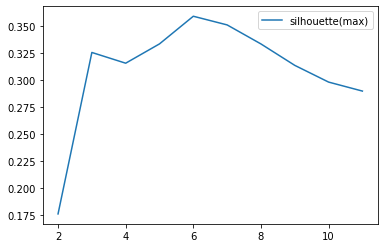

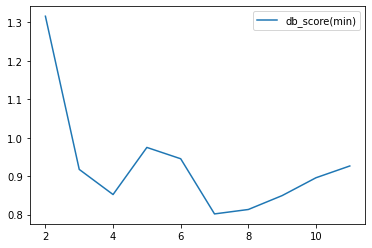

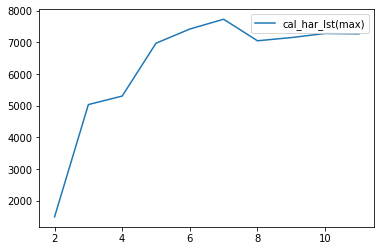

<Figure size 432x288 with 0 Axes>

In [30]:
res = [brc_silhouette, brc_db_score, brc_cal_har_lst]
names = ['silhouette(max)', 'db_score(min)', 'cal_har_lst(max)']
for i in range(3):
    sns.lineplot(x=list(range(2,12)),y=res[i],label=names[i])
    plt.figure()

### Gaussian mixture

In [31]:
flag = False
gm_silhouette= []
gm_db_score=[]
gm_cal_har_lst=[]
gm_bic = []
gm_aic = []
for i in range(2,12):
    print(i)
    gm = GaussianMixture(n_components=i).fit(train)
    preds = gm.predict(train)
    silhouette = silhouette_score(train,preds)
    gm_silhouette.append(silhouette)
    db = davies_bouldin_score(train,preds)
    gm_db_score.append(db)
    cal_har = calinski_harabasz_score(train,preds)
    gm_cal_har_lst.append(cal_har)
    gm_bic.append(gm.bic(train))
    gm_aic.append(gm.aic(train))
    if flag:
        print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
        print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
        print("calinski-harabasz score for number of cluster(s) {}: {}".format(i,cal_har))
        print("-"*100)
print("DONE")

2
3
4
5
6
7
8
9
10
11
DONE


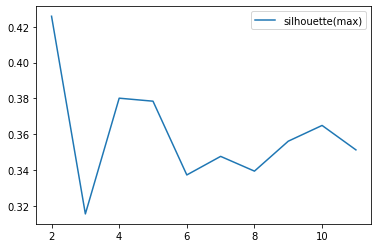

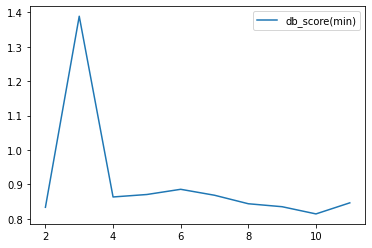

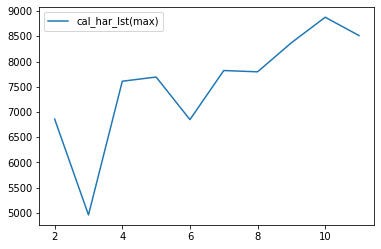

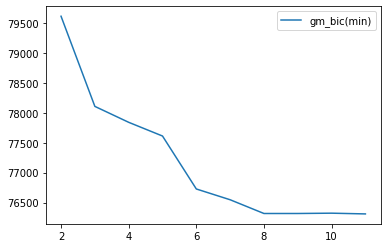

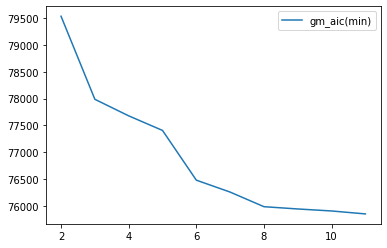

<Figure size 432x288 with 0 Axes>

In [32]:
res = [gm_silhouette, gm_db_score, gm_cal_har_lst,gm_bic,gm_aic]
names = ['silhouette(max)', 'db_score(min)', 'cal_har_lst(max)', 'gm_bic(min)','gm_aic(min)']
for i in range(5):
    sns.lineplot(x=list(range(2,12)),y=res[i],label=names[i])
    plt.figure()

### AgglomerativeClustering

In [33]:
flag = False
ac_silhouette= []
ac_db_score=[]
ac_cal_har_lst=[]
for i in range(2,12):
    print(i)
    ac = AgglomerativeClustering(n_clusters=i).fit(train)
    preds = ac.labels_
    silhouette = silhouette_score(train,preds)
    ac_silhouette.append(silhouette)
    db = davies_bouldin_score(train,preds)
    ac_db_score.append(db)
    cal_har = calinski_harabasz_score(train,preds)
    ac_cal_har_lst.append(cal_har)
    if flag:
        print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
        print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
        print("calinski-harabasz score for number of cluster(s) {}: {}".format(i,cal_har))
        print("-"*100)
print("DONE")

2
3
4
5
6
7
8
9
10
11
DONE


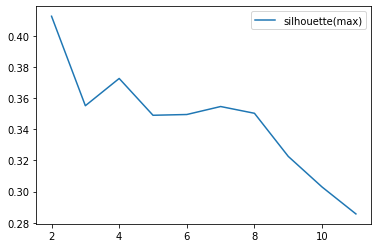

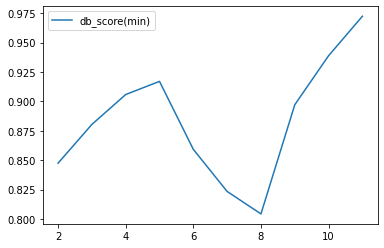

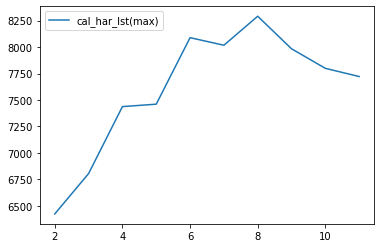

<Figure size 432x288 with 0 Axes>

In [34]:
res = [ac_silhouette, ac_db_score, ac_cal_har_lst]
names = ['silhouette(max)', 'db_score(min)', 'cal_har_lst(max)']
for i in range(3):
    sns.lineplot(x=list(range(2,12)),y=res[i],label=names[i])
    plt.figure()

7. Для алгоритма DBSCAN необходимо выполнить шаги из пункта 6, однако подбор значений будет осуществляться по параметрам модели min_samples и eps. Найти наиболее оптимальное число кластеров за счёт этих параметров.

## DBSCAN

<Figure size 432x288 with 0 Axes>

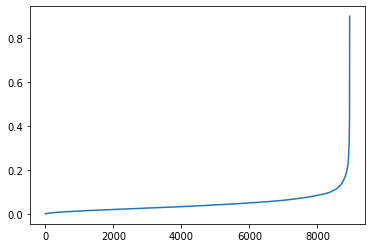

<Figure size 432x288 with 0 Axes>

In [35]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(train)
distances, indices = neighbors_fit.kneighbors(train)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.figure()

0.2439036876798506

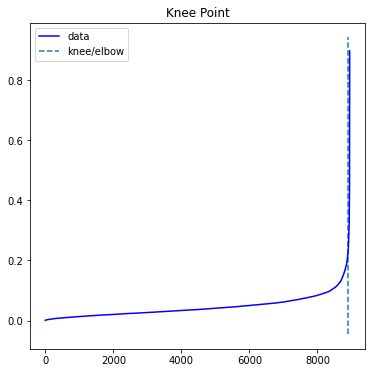

In [37]:
kl = KneeLocator(x = list(range(len(distances))),y=distances,curve='convex',direction='increasing')
eps = distances[kl.knee]
kl.plot_knee()
eps

In [47]:
D = DBSCAN(eps=eps,min_samples=10).fit(train)
print(len(np.unique(D.labels_)))
print(list(D.labels_).count(-1))

6
309


In [51]:
#models.append(D)

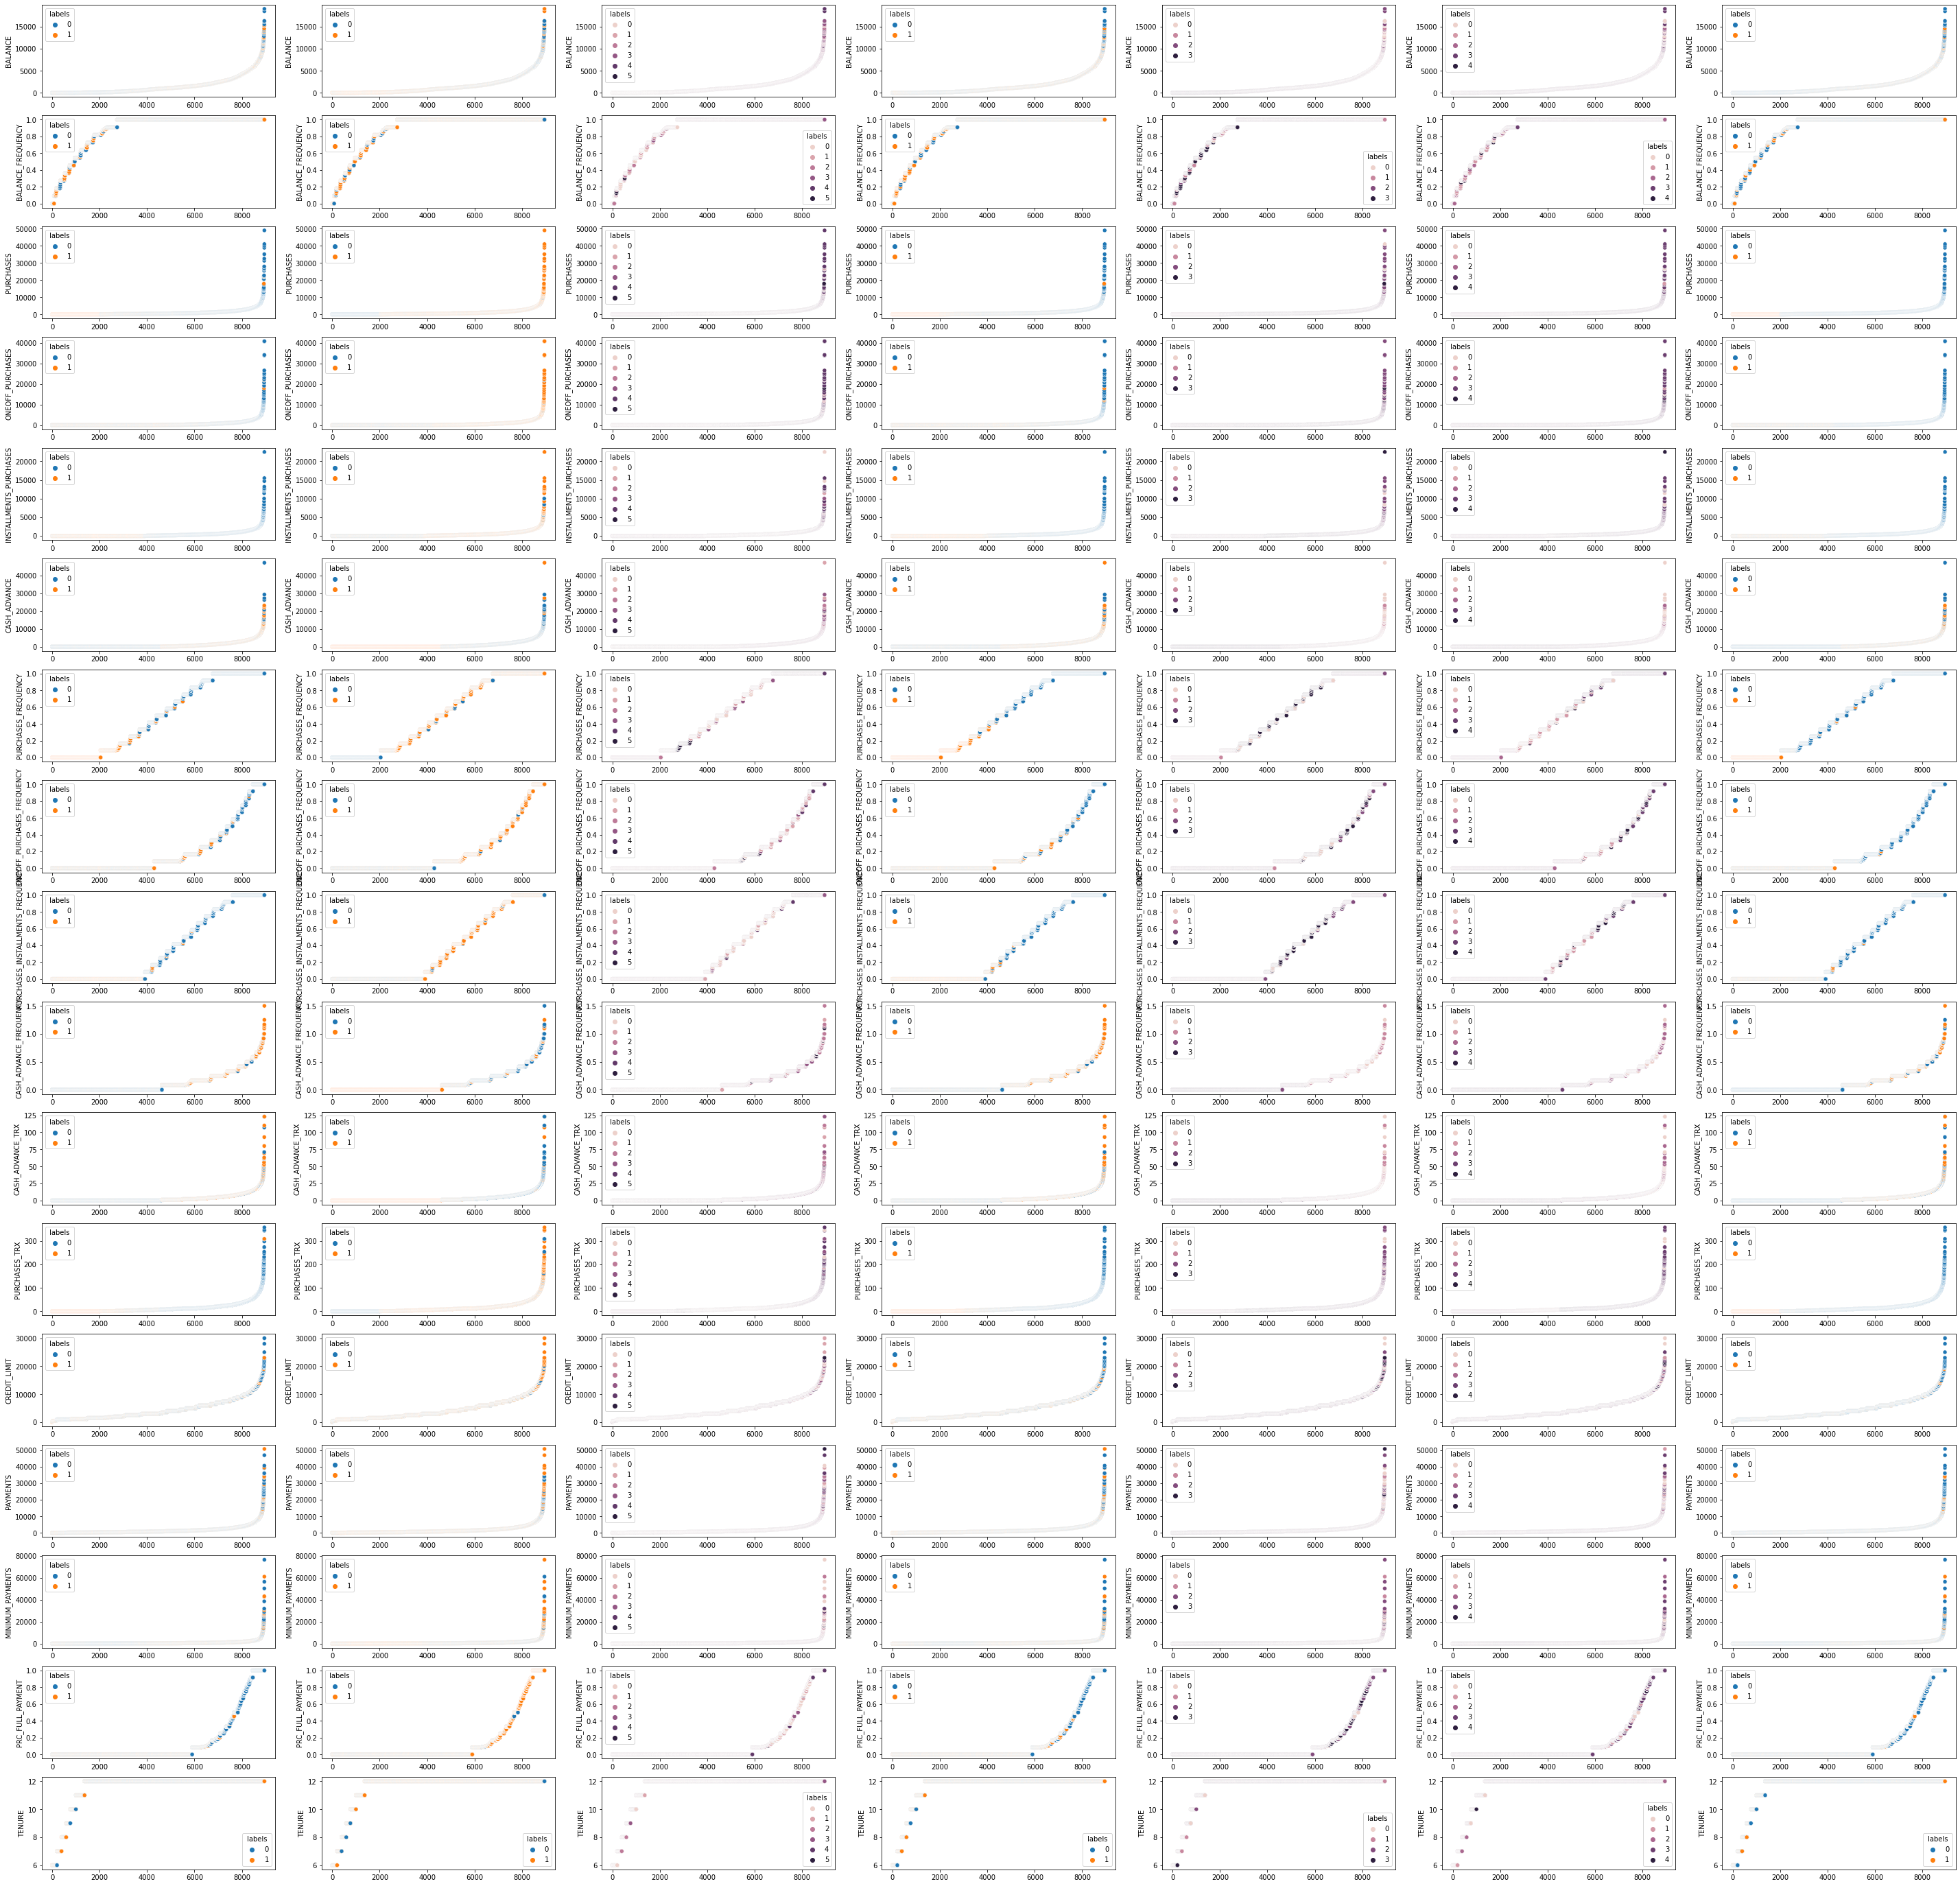

In [323]:
data = pd.read_csv('data/CC GENERAL.csv')
data.CREDIT_LIMIT = data.CREDIT_LIMIT.fillna(np.exp(data.CREDIT_LIMIT.aggregate(np.log).mean()))
data.MINIMUM_PAYMENTS = data.MINIMUM_PAYMENTS.fillna(0)
data = data.drop(columns=['CUST_ID'])
number_clusters = []
for i in models:
    if hasattr(i,'n_components'):
        number_clusters.append(i.n_components)
    else:
        number_clusters.append(i.n_clusters)
a = len(data.keys())
b = len(models)
f = plt.figure(figsize=(50,50))
cnt = 0
for i in data.keys():
    for model in models:
        if hasattr(model,'labels_'):
            labels = model.labels_
        else:
            labels = model.predict(train)
        data['labels'] = labels
        f.add_subplot(a,b,cnt+1)
        sns.scatterplot(data=data.sort_values(by=i),x=list(range(len(data))),y=i,hue='labels',legend=True)
        
        cnt += 1

In [41]:
data = pd.read_csv('data/CC GENERAL.csv')
data.CREDIT_LIMIT = data.CREDIT_LIMIT.fillna(data.CREDIT_LIMIT.mean())
data.MINIMUM_PAYMENTS = data.MINIMUM_PAYMENTS.fillna(data.MINIMUM_PAYMENTS.mean())
data = data.drop(columns=['CUST_ID'])

In [42]:
def show_plot(data,col_1,col_2):
    for model in models:
        if hasattr(model,'labels_'):
            labels = model.labels_
        else:
            labels = model.predict(train)
        data['labels'] = labels
        sns.scatterplot(data=data[[col_1,col_2,'labels']],x=col_1,y=col_2,hue='labels',legend=True)
        plt.figure()

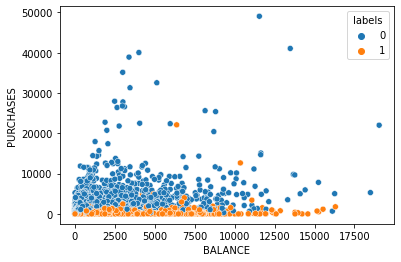

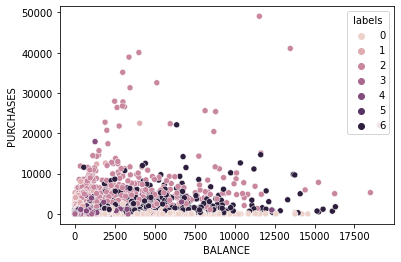

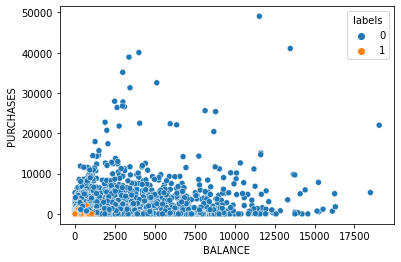

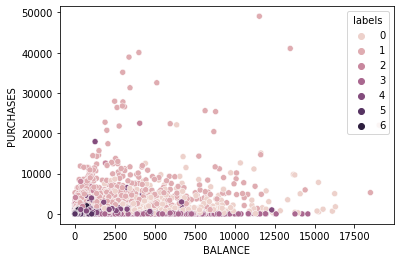

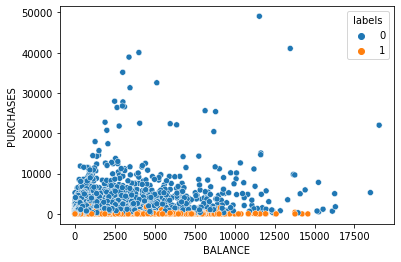

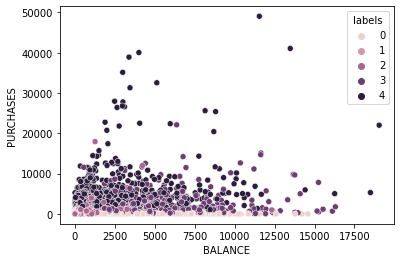

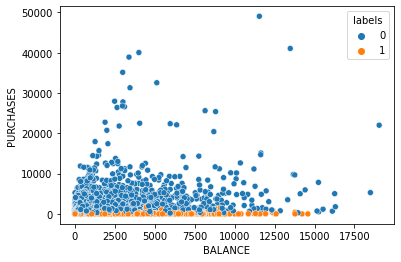

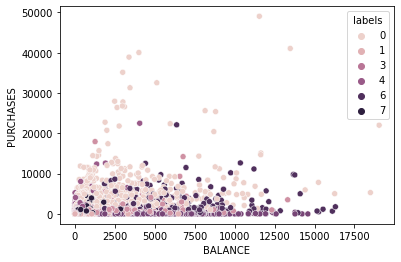

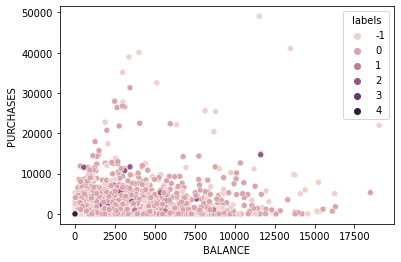

<Figure size 432x288 with 0 Axes>

In [64]:
show_plot(data,'BALANCE','PURCHASES')

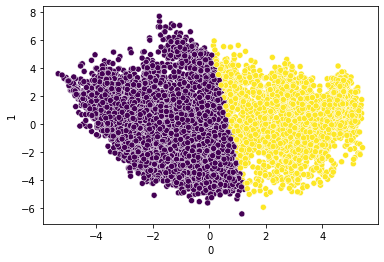

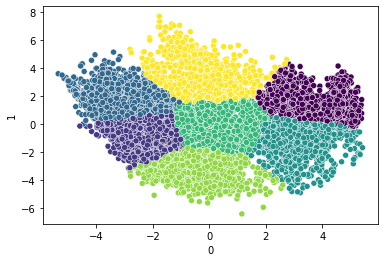

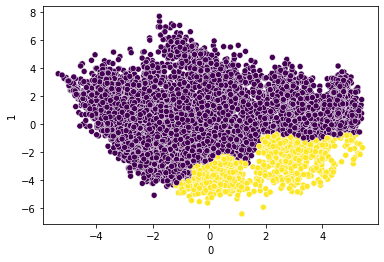

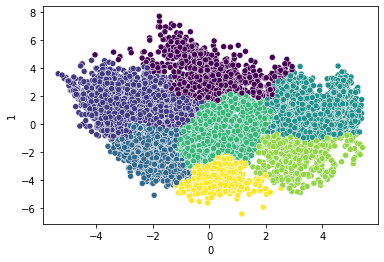

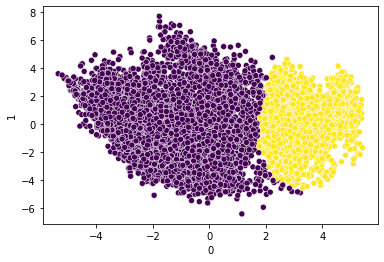

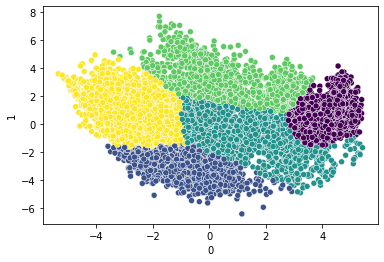

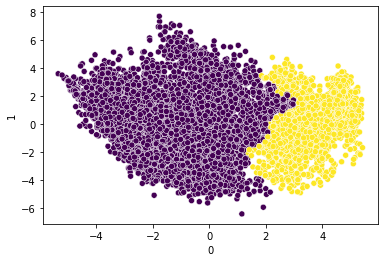

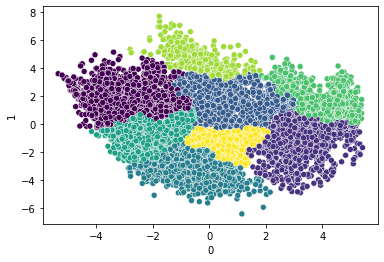

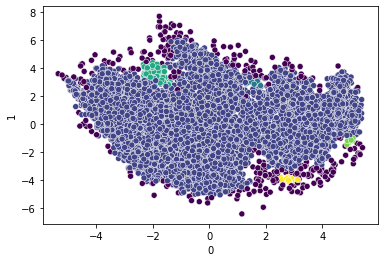

<Figure size 432x288 with 0 Axes>

In [55]:
#pca2 = PCA(n_components=2)
#tmp = pca2.fit_transform(train)
tmp = train
for model in models:
    if hasattr(model,'labels_'):
        labels = model.labels_
    else:
        labels = model.predict(train)
    
    sns.scatterplot(x=tmp[0],y=tmp[1],c=labels,legend=True)
    plt.figure()


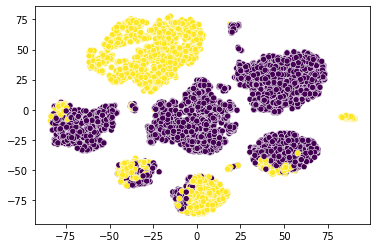

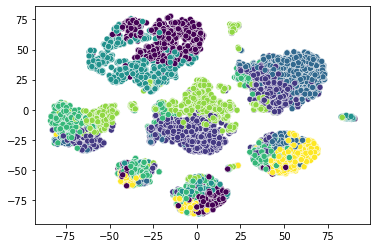

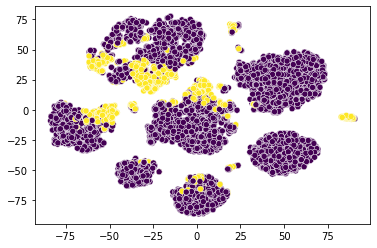

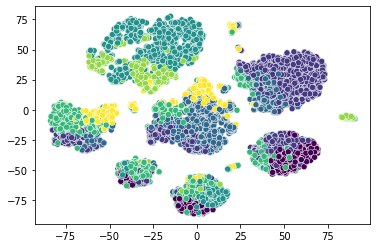

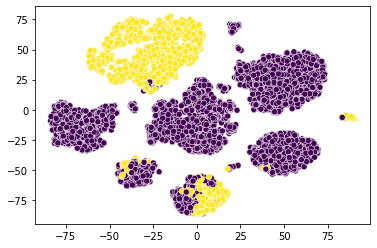

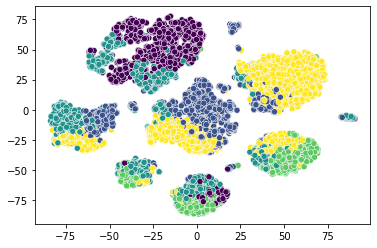

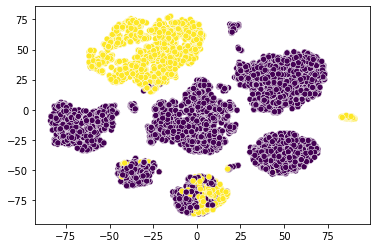

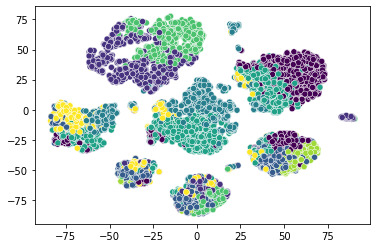

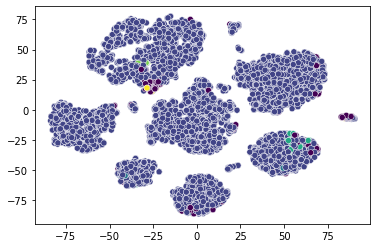

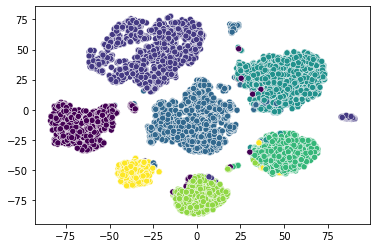

<Figure size 432x288 with 0 Axes>

In [74]:
#tsne2 = TSNE(n_components=2)
#tmp = tsne2.fit_transform(train_copy)

for model in models:
    if hasattr(model,'labels_'):
        labels = model.labels_
    else:
        labels = model.predict(train)
    
    sns.scatterplot(x=tmp[:,0],y=tmp[:,1],c=labels,legend=True)
    plt.figure()

In [73]:
models.append(KMeans(n_clusters=7,random_state=0).fit(train_copy))